## **Цели и задачи исследования**
***
**Цель исследования** - *построить модель, которая бы предсказывала стоимость автомобиля по его характеристикам.*

*Целью исследования определяются следующие* **задачи:**

* *собрать актуальную информацию по характеристикам и ценам на автомобили с сайта [Auto.ru](https://auto.ru/ "Сайт Auto.ru") с помощью парсинга*;
* *провести разведавательный анализ данных;*
* *разработать модель, которая бы предсказывала цену автомобиля.*



<img src="https://cdnimg.rg.ru/img/content/208/02/46/renault_sandero_stepway_ru-spec_15_d_850.jpeg" />

### 1. Импортирование библиотек

In [1]:
# библиотеки для работы с dataset
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

# опции для вывода данных в нужном количестве и формате
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# системная библиотека
import sys

# библиотеки для ML
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

# библиотеки для парсинга сайта
import requests, json

# библиотека для перевода слов
import goslate
gs = goslate.Goslate()

# библиотеки для визуализации
import altair as alt
# отключение ограничения в 5000 строк для alt
alt.data_transformers.disable_max_rows()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# библиотеки для статистического анализа
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import chi2

### 2. Обеспечение воспроизводимости экспериментов

In [2]:
# Определяем версии Python и библиотеки Numpy
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Numpy        : 1.16.5


In [3]:
# фиксация версий пакетов, для воспроизводимсти экспериментов
!pip freeze > requirements.txt

In [4]:
# фиксация random_seed для воспроивзодимости экспериментов
RANDOM_SEED = 42

### 3. Определение метрики качества модели

*MAPE(Mean Percentage Absolute Error)- средняя абсолютная ошибка в процентах.*
$$MAPE={1\over{n}}+{\sum{|y-\bar{Y}|\over\bar{Y}}}$$

*где:*
* y  - *фактическое значение за анализируемый период;*
* Y - *значение прогнозной модели за анализируемый период;*
* n - *количество периодов.*

In [5]:
# функция для расчета средней абсолютной ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

### 4. Переменные

In [6]:
VERSION = 16
VAL_SIZE = 0.20

### 5. Функции, используемые для обработки данных

In [7]:
def description_column(x):
    
    """Функция используется для описания 
     столбца текстового типа """
    
    print('Количество уникальных значений в столбце:',x.nunique())
    print('Перечень уникальных значений:', x.unique())
    print('Длина столбца:',len(x))
    print('Количество значений "NaN":', x.isna().sum())
    print("Количество значений, встретившихся в столбце более 10 раз:", (x.value_counts()>10).sum())

def description_column_count(x):
    
    """Функция используется для описания 
     столбца числового типа """
    
    print('Длина столбца:',len(x))
    print('Количество значений "NaN":', x.isna().sum())
    print('Минимальное значение:', x.min())
    print('Максимальное значение:',x.max())  
    
def outliers(x): 
    
    """Функция используется для 
    определения границ выбросов"""
    
    median = x.median()
    IQR = x.quantile(0.75)-x.quantile(0.25)
    q25 = x.quantile(0.25)
    q75 = x.quantile(0.75)
    print('25-й квартиль: {},'.format(q25), '75-й квартиль: {},'.format(q75), 'IQR: {},'.format(IQR),
     "границы выбросов: [{x_min},{x_max}].".format(x_min = q25-1.5*IQR, x_max = q75+1.5*IQR))

def delete_outliers(x): 
    
    """Функция используется для 
    очистки данных от выбросов"""
    
    median = x.median()
    IQR = x.quantile(0.75)-x.quantile(0.25)
    q25 = x.quantile(0.25)
    q75 = x.quantile(0.75)
    x_min =q25-1.5*IQR
    x_max =q75+1.5*IQR
    return x_min, x_max
    
def boxplot(x1,y1,d,t,tx,ty):
    
    """Функция используется для 
    вывода boxplot по нескольким признакам"""
    
    red_square = dict(markerfacecolor='k', marker='s')
    plt.figure(figsize=(18, 5))
    plt.style.use('seaborn')
    sns.boxplot(x=x1, y=y1, data=d, linewidth=1, flierprops=red_square)
    plt.title(t, fontsize=15, color='black')
    plt.xlabel(tx, fontsize=15, color='black')
    plt.ylabel(ty, fontsize=15, color='black')
    plt.tick_params(axis='both', labelsize=15)
    plt.grid(True)
    

def one_boxplot(x, title, x_title):
    
    """Функция используется для 
    вывода boxplot по одному признаку"""
    
    red_square = dict(markerfacecolor='k', marker='s')
    plt.figure(figsize=(18, 5))
    plt.style.use('seaborn')
    plt.tick_params(axis='both', labelsize=15)
    ax=sns.boxplot(x, linewidth=1, flierprops=red_square)
    ax.set_title(title, fontsize=15, color='black')
    ax.set_xlabel(x_title, fontsize=15, color='black')

def correlation(x,y):
    
    """Функция используется для 
    расчета коэффициента корреляции""" 
        
    display(pd.DataFrame(all_data[[x,y]].corr()))

def get_stat_dif(column):
    cols = all_data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(all_data.loc[all_data.loc[:, column] == comb[0], 'score'], 
                        all_data.loc[all_data.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

def cm_to_inch(value):
    return value/2.54

def bar_pivot_table(x,z,y,c,t,xl,yl):
    
    """Функция используется для 
    вывода диаграммы по одному признаку"""
    
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (20,7)
    all_data.pivot_table(values = [x, z], index = [y], aggfunc = c).plot(kind = 'area', title = t)
    plt.xlabel(xl, fontsize=15, color='black')
    plt.ylabel(yl, fontsize=15, color='black')
    plt.title(t, fontsize=15, color='black')
    plt.tick_params(axis='both', labelsize=15)
    plt.legend(loc='lower right', facecolor='black', fontsize=15)
    plt.legend()
    plt.grid(False)
    plt.show()

def area_two_pivot_table(x,z,y,c,t,xl,yl):
    
    """Функция используется для 
    вывода диаграммы по одному признаку"""
    
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (20,7)
    all_data.pivot_table(values = [x], index = [y], columns=[z], aggfunc = c).plot(kind = 'area',stacked=True,title = t)
    plt.xlabel(xl, fontsize=15, color='black')
    plt.ylabel(yl, fontsize=15, color='black')
    plt.legend()
    plt.grid(False)
    plt.show()
    
def share(x, x_name, y_name, title):
    
    """Функция используется для 
    вывода диаграммы по долям"""
    
    new=pd.DataFrame(x.value_counts(normalize = True)*100).reset_index(level=0).head(10)
    new.columns=([x_name, y_name])
    plt.style.use('seaborn')
    plt.figure(figsize=(18, 5))
    plt.tick_params(axis='both', labelsize=15)
    ax=sns.barplot(x=x_name, y=y_name, data=new)   
    ax.set_ylabel(y_name, fontsize=15, color='black')
    ax.set_xlabel(x_name, fontsize=15, color='black')
    ax.set_title(title, fontsize=15, color='black')
    for counter, value in enumerate(new[y_name]):
        ax.text(counter, value, round(value), ha='left', size=16)


def share_count(x, x_name, y_name, title):
    
    """Функция используется для 
    вывода диаграммы по долям"""
    
    new=pd.DataFrame(x.value_counts()).reset_index(level=0).head(10).sort_values(by=['index'])
    new.columns=([x_name, y_name])
    plt.style.use('seaborn')
    plt.figure(figsize=(18, 5))
    plt.tick_params(axis='both', labelsize=15)
    ax=sns.barplot(x=x_name, y=y_name, data=new)
    ax.set_ylabel(y_name, fontsize=15, color='black')
    ax.set_xlabel(x_name, fontsize=15, color='black')
    ax.set_title(title, fontsize=15, color='black')
    for counter, value in enumerate(new[y_name]):
        ax.text(counter, value, round(value), ha='center', size=16)

def bar_groupby(x,y,z,t,xl,yl):
    
    """Функция используется для 
    вывода диаграммы по нескольким признакам"""
    
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (20,7)
    all_data.groupby(by=[x,y])[z].value_counts(normalize=True).plot(kind='bar', title=t)
    plt.xlabel(xl, fontsize=15, color='black')
    plt.ylabel(yl, fontsize=15, color='black')
    plt.tick_params(axis='both', labelsize=15)
    plt.grid(True)
    plt.show()

def hist_(x):
    plt.style.use('seaborn')
    plt.tick_params(axis='both', labelsize=15)
    plt.hist(x)
    
def correlation_vis(x_name, y_name, title):
    
    """Функция используется для 
    вывода графика распределения"""
    
    plt.style.use('seaborn')
    ax = sns.jointplot(x=x_name, y=y_name, data=df_corr, kind='scatter')

def altair_bar(data, x_name, y_name, legend_name, title_name):
    
    bar = alt.Chart(data,title=title_name).mark_bar(size=100).encode(
    x=alt.X(x_name, axis=alt.Axis(title=x_name, labelFontSize=13, titleFontSize=13, labelAngle=360)),
    y=alt.Y(y_name, axis=alt.Axis(title=y_name, labelFontSize=13, titleFontSize=13)),
    text=y_name,
    color=alt.value("SteelBlue"),
    size=alt.value(13)
    )

    text = bar.mark_text(
    align='center',
    baseline='middle',
    angle=0,
    dy=-5).encode(
    text=alt.Text(y_name, format="s"),
    color=alt.value("black"))
    
    return (bar + text).properties(height=250, width=840)

def altair_bar_share(data, x_name, y_name, title_name, sort):
    
    new=pd.DataFrame(data.value_counts(normalize = True)).reset_index(level=0).head(10).sort_values(by=sort, 
                                                                                                    ascending=False)
    new.columns=([x_name, y_name])
    
    bar = alt.Chart(new, title=title_name).mark_bar(orient='horizontal').encode(
    y=alt.Y(x_name, axis=alt.Axis(title=x_name, labelFontSize=13, titleFontSize=13)),
    x=alt.X(y_name, axis=alt.Axis(title=y_name, format='%', labelFontSize=13, titleFontSize=13)),
    text=y_name,
    color=alt.value("SteelBlue"),
    size=alt.value(13)
    )

    text = bar.mark_text(
    align='center',
    baseline='middle',
    angle=0,
    dx=40).encode(
    text=alt.Text(y_name, format="p"),
    color=alt.value("black"))
    
    return (bar + text).properties(height=250, width=820)

def hist(data, x1, x2, ylabel, xlabel, title):
    bins = np.arange(0, x1, x2)
    plt.style.use('seaborn')
    _, ax = plt.subplots(figsize=(18, 5))
    plt.tick_params(axis='both', labelsize=15)
    ax.hist(data, bins = bins)
    ax.set_ylabel(ylabel, fontsize=15, color='black')
    ax.set_xlabel(xlabel, fontsize=15, color='black')
    ax.set_title(title, fontsize=15, color='black')

### 6. Сбор данных и формирование тренировочного dataset

**Комментарий**: *Для создания ML модели, предсказывающей стоимость автомобиля не хватает акутальных данных. Необходимо собрать информацию с сайта [Auto.ru](https://auto.ru/ "Сайт Auto.ru") с помощью парсинга.*

In [8]:
# ссылка, по которой лежат данные и куда будет передан POST запрос с параметрами
# url='https://auto.ru/-/ajax/desktop/listing/'

In [9]:
# заголовки запроса
headers = """
Host: auto.ru
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:74.0) Gecko/20100101 Firefox/74.0
Accept: */*
Accept-Language: ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3
Accept-Encoding: gzip, deflate, br
Referer: https://auto.ru/cars/all/?top_days=1&year_from=1890&year_to=2021&page=2
x-client-app-version: e1e19dc95df
x-page-request-id: 84d9c1ebcd26ce0180f887982ad272a8
x-client-date: 1623918157662
x-csrf-token: 6da8ffea230eea0863601675d68560d57061c57bb7267e06
x-requested-with: fetch
content-type: application/json
X-KL-Ajax-Request: Ajax_Request
Origin: https://auto.ru
Content-Length: 91
Connection: keep-alive
Cookie: _csrf_token=6da8ffea230eea0863601675d68560d57061c57bb7267e06; autoru_sid=a%3Ag60caf8e323c861n8k6gbkot3h0s1tb6.91fe2c562185a4a1326a7d1c27b3eaa0%7C1623914723236.604800.tuORHRMWIkPzETrFBJkSpA.DMoK-CYOt0wXSFr_Kla-EhewJGG19bRfEo7GKF634Hw; autoruuid=g60caf8e323c861n8k6gbkot3h0s1tb6.91fe2c562185a4a1326a7d1c27b3eaa0; suid=305432ef193b81eecc5b7af2cb76cf70.cb93241c5fc46d5e723a99df560f314a; from_lifetime=1623918516562; from=direct; salon_phone_utms=utm_medium%3Ddesktop%26utm_source%3Dauto_wizard%26utm_campaign%3Dcommon.tabs.tabs_generation_recommend.exp_tabs_generation_recommend%26utm_content%3Dlisting; X-Vertis-DC=vla; yuidlt=1; yandexuid=4858703531584026877; crookie=EIjVgzGzjUjuPaFVNqaO4ZzfoYTa6NAIBGPZP3MlFrO2brx9NXOTKzE5k9wlqZBGHjiA41i7J+Fq7y49epN363wC06M=; cmtchd=MTYyMzkxNDM3ODk3MQ==; gdpr=0; cycada=VJcuXNud2Kst+WWmr8SHvGA1lKSuD8M6rDi+9dja1Hk=; _ym_uid=162391437940542129; _ym_d=1623918516; _ym_isad=2; listing_view_session={%22top_days%22:%221%22}; listing_view=%7B%22version%22%3A1%7D
""".strip().split('\n')

# т.к. параметр headers принимает на вход словарь, изменим строку
# dict_headers={}
# for header in headers:
#    key, value =  header.split(': ')
#    dict_headers[key] = value

In [10]:
# сохраняем данные по машинам
offers = []

# цикл собирает данные с 1 по 500 страницу по всем параметрам за последние 30 дней
for x in range(1, 500):
    param = {"category":"cars",
         "page":x,
         "section":"all",
         "top_days":"30",
         "year_from":1890,
         "year_to":2021,
        }
    # выполняем запрос (код 200 успех, 400 ошибка)
    # response = requests.post(url, json=param, headers=dict_headers)
    
    # сохраняем результаты в data
    # data = response.json()
    
    # берем не все данные, а только описание машин во вкладке offers
    # offers.extend(data['offers'])
    
    
# сохранить результаты запроса в json
# with open("data.json", 'w') as f:
#     json.dump(offers, f)

In [11]:
# загуржает dataset с данными
with open("data.json", 'r', encoding='utf8') as f:
    data = json.load(f)

In [12]:
print("Длина полученного dataset:",len(data), "строки.")

Длина полученного dataset: 18962 строки.


**Комментарий**: *из всего объема собранных данных (файл data.json) необходимо выбрать признаки, повторяющиеся в тестовом dataset (файл test.csv).*

In [13]:
# собираем столбцы тренировочного dataset
color = []
for item in data:
    try:
        color.append(item['color_hex'])
    except KeyError:
        color.append(0)
print("Длина стобца color:",len(color))

modelDate = []
for item in data:
    try:
        modelDate.append(item['documents']['year'])
    except KeyError:
        modelDate.append(0)
print("Длина стобца modelDate:",len(modelDate))

owner_number = []
for item in data:
    try:
        owner_number.append(item['documents']['owners_number'])
    except KeyError:
        owner_number.append(0)
print("Длина стобца owner_number:",len(owner_number))

pts = []
for item in data:
    try:
        pts.append(item['documents']['pts'])
    except KeyError:
        pts.append(0)
print("Длина стобца pts:",len(pts))

price = []
for item in data:
    try:
        price.append(item['price_info']['price'])
    except KeyError:
        price.append(0)
print("Длина стобца price:",len(price))

currency = []
for item in data:
    try:
        currency.append(item['price_info']['currency'])
    except KeyError:
        currency.append(0)
print("Длина стобца currency:",len(currency))
                                                             
numberOfDoors = []
for item in data:
    try:
        numberOfDoors.append(item['vehicle_info']['configuration']['doors_count'])
    except KeyError:
        numberOfDoors.append(0)
print("Длина стобца numberOfDoors:",len(numberOfDoors))
                                                               
bodyType = []
for item in data:
    try:
        bodyType.append(item['vehicle_info']['configuration']['human_name'])
    except KeyError:
        bodyType.append(0)
print("Длина стобца bodyType:",len(bodyType))
                                                                                                                              
brand = []
for item in data:
    try:
        brand.append(item['vehicle_info']['mark_info']['code'])
    except KeyError:
        brand.append(0)
print("Длина стобца brand:",len(brand))
                                                               
displacement = []
for item in data:
    try:
        displacement.append(item['vehicle_info']['tech_param']['displacement'])
    except KeyError:
        displacement.append(0)
print("Длина стобца displacement:",len(displacement))
                                                               
fuelType = []
for item in data:
    try:
        fuelType.append(item['vehicle_info']['tech_param']['engine_type'])
    except KeyError:
        fuelType.append(0)
print("Длина стобца fuelType:",len(fuelType)) 

gear_type = []
for item in data:
    try:
        gear_type.append(item['vehicle_info']['tech_param']['gear_type'])
    except KeyError:
        gear_type.append(0)
print("Длина стобца gear_type:",len(gear_type)) 

transmission = []
for item in data:
    try:
        transmission.append(item['vehicle_info']['tech_param']['transmission'])
    except KeyError:
        transmission.append(0)
print("Длина стобца transmission:",len(transmission)) 
                                                               
power = []
for item in data:
    try:
        power.append(item['vehicle_info']['tech_param']['power'])
    except KeyError:
        power.append(0)
print("Длина стобца power:",len(power)) 
                                                               
power_kvt = []
for item in data:
    try:
        power_kvt.append(item['vehicle_info']['tech_param']['power_kvt'])
    except KeyError:
        power_kvt.append(0)
print("Длина стобца power_kvt:",len(power_kvt)) 
                                                               
acceleration = []
for item in data:
    try:
        acceleration.append(item['vehicle_info']['tech_param']['acceleration'])
    except KeyError:
        acceleration.append(0)
print("Длина стобца acceleration:",len(acceleration)) 
                                                               
clearance_min = []
for item in data:
    try:
        clearance_min.append(item['vehicle_info']['tech_param']['clearance_min'])
    except KeyError:
        clearance_min.append(0)
print("Длина стобца clearance_min:",len(clearance_min)) 

fuel_rate = []
for item in data:
    try:
        fuel_rate.append(item['vehicle_info']['tech_param']['fuel_rate'])
    except KeyError:
        fuel_rate.append(0)
print("Длина стобца fuel_rate:",len(fuel_rate)) 

mileage = []
for item in data:
    try:
        mileage.append(item['state']['mileage'])
    except KeyError:
        mileage.append(0)
print("Длина стобца mileage:",len(mileage)) 


model_name = []
for item in data:
    try:
        model_name.append(item['vehicle_info']['model_info']['code'])
    except KeyError:
        model_name.append(0)
print("Длина стобца model_name:",len(model_name)) 

name = []
for item in data:
    try:
        name.append(item['vehicle_info']['tech_param']['human_name'])
    except KeyError:
        name.append(0)
print("Длина стобца name:",len(name)) 

vendor = []
for item in data:
    try:
        vendor.append(item['vehicle_info']['vendor'])
    except KeyError:
        vendor.append(0)
print("Длина стобца vendor:",len(vendor))

wheel = []
for item in data:
    try:
        wheel.append(item['vehicle_info']['steering_wheel'])
    except KeyError:
        wheel.append(0)
print("Длина стобца wheel:",len(wheel))

Длина стобца color: 18962
Длина стобца modelDate: 18962
Длина стобца owner_number: 18962
Длина стобца pts: 18962
Длина стобца price: 18962
Длина стобца currency: 18962
Длина стобца numberOfDoors: 18962
Длина стобца bodyType: 18962
Длина стобца brand: 18962
Длина стобца displacement: 18962
Длина стобца fuelType: 18962
Длина стобца gear_type: 18962
Длина стобца transmission: 18962
Длина стобца power: 18962
Длина стобца power_kvt: 18962
Длина стобца acceleration: 18962
Длина стобца clearance_min: 18962
Длина стобца fuel_rate: 18962
Длина стобца mileage: 18962
Длина стобца model_name: 18962
Длина стобца name: 18962
Длина стобца vendor: 18962
Длина стобца wheel: 18962


In [14]:
# формируем тренировочный dataframe
df = pd.DataFrame(pd.concat([pd.Series(color), pd.Series(modelDate), pd.Series(owner_number), pd.Series(price),
                             pd.Series(currency),  pd.Series(numberOfDoors), pd.Series(bodyType),  pd.Series(brand), 
                             pd.Series(displacement), pd.Series(fuelType), pd.Series(gear_type), pd.Series(transmission), 
                             pd.Series(power), pd.Series(power_kvt), pd.Series(acceleration), pd.Series(clearance_min), 
                             pd.Series(fuel_rate), pd.Series(mileage), pd.Series(model_name), 
                             pd.Series(name), pd.Series(vendor), pd.Series(pts), pd.Series(wheel)], axis=1))

In [15]:
# переименуем столбцы
df.columns=['color', 'year', 'owner', 'price', 'currency', 'doors', 'bodyType',  'brand', 'displacement', 
            'engine_type', 'gear_type', 'transmission', 'power', 'power_kvt', 'acceleration', 'clearance_min', 'fuel_rate', 
            'mileage','model_name','name','vendor', 'pts', 'wheel']

In [16]:
print("В скольких строках не проставлена цена машины:",len(df[df['price']==0]))

В скольких строках не проставлена цена машины: 499


In [17]:
# сохраняю только те строки, где цена проставлена
df_train = df[df['price']>0]

In [18]:
# помечаем, что это тренировочный dataframe
df_train['sample']= 'train'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
df_train.head(2)

,color,year,owner,price,currency,doors,bodyType,brand,displacement,engine_type,gear_type,transmission,power,power_kvt,acceleration,clearance_min,fuel_rate,mileage,model_name,name,vendor,pts,wheel,sample
0,97948F,2002,4,74990,RUR,4,Седан,VAZ,1596,GASOLINE,FORWARD_CONTROL,MECHANICAL,90,66,12.0,170,7.2,242000,2110,1.6 MT (90 л.с.),RUSSIAN,DUPLICATE,LEFT,train
1,040001,2015,2,1320000,RUR,5,Внедорожник 5 дв.,VOLKSWAGEN,1968,DIESEL,ALL_WHEEL_DRIVE,AUTOMATIC,140,103,10.7,200,7.1,152000,TIGUAN,2.0d AT (140 л.с.) 4WD,EUROPEAN,ORIGINAL,LEFT,train


In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18463 entries, 0 to 18961
Data columns (total 24 columns):
color            18463 non-null object
year             18463 non-null int64
owner            18463 non-null int64
price            18463 non-null int64
currency         18463 non-null object
doors            18463 non-null int64
bodyType         18463 non-null object
brand            18463 non-null object
displacement     18463 non-null int64
engine_type      18463 non-null object
gear_type        18463 non-null object
transmission     18463 non-null object
power            18463 non-null int64
power_kvt        18463 non-null int64
acceleration     18463 non-null float64
clearance_min    18463 non-null int64
fuel_rate        18463 non-null float64
mileage          18463 non-null int64
model_name       18463 non-null object
name             18463 non-null object
vendor           18463 non-null object
pts              18463 non-null object
wheel            18463 non-null object
s

### 7. Формирование тестового dataframe

In [21]:
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [22]:
test.head(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [23]:
# выбираем столбцы, которые повторяются в тренировочном dataset
test=test[['color','productionDate','Владельцы','priceCurrency','numberOfDoors','bodyType','brand','super_gen','mileage',
     'model_name','name','vendor','ПТС','Руль']]

# переименуем столбец name, чтобы при деление super_gen на столбцы в след. шагах названия не дублировались
test.columns = (['color','productionDate','Владельцы','priceCurrency','numberOfDoors','bodyType','brand','super_gen','mileage',
     'model_name','name_','vendor','ПТС','Руль'])
test.head(2)

,color,productionDate,Владельцы,priceCurrency,numberOfDoors,bodyType,brand,super_gen,mileage,model_name,name_,vendor,ПТС,Руль
0,синий,2014,3 или более,RUB,5,лифтбек,SKODA,"{""id"":""10373605"",""displacement"":1197,""engine_t...",74000,OCTAVIA,1.2 AMT (105 л.с.),EUROPEAN,Оригинал,Левый
1,чёрный,2017,1 владелец,RUB,5,лифтбек,SKODA,"{""id"":""20913311"",""displacement"":1598,""engine_t...",60563,OCTAVIA,1.6 MT (110 л.с.),EUROPEAN,Оригинал,Левый


In [24]:
# столбец super_gen нужно из str преобразовать в dict
test['super_gen'] = test['super_gen'].apply(lambda x: json.loads(x))

# разносим элементы dict по столбцам
test= pd.concat([test, json_normalize(test['super_gen'])], axis=1).drop(['super_gen'], axis=1)
test.head(2)

,color,productionDate,Владельцы,priceCurrency,numberOfDoors,bodyType,brand,mileage,model_name,name_,vendor,ПТС,Руль,id,displacement,engine_type,gear_type,transmission,power,power_kvt,human_name,acceleration,clearance_min,fuel_rate,nameplate,clearance_max,name
0,синий,2014,3 или более,RUB,5,лифтбек,SKODA,74000,OCTAVIA,1.2 AMT (105 л.с.),EUROPEAN,Оригинал,Левый,10373605,1197,GASOLINE,FORWARD_CONTROL,ROBOT,105,77,1.2 AMT (105 л.с.),10.5,155.0,5.0,NaN,NaN,NaN
1,чёрный,2017,1 владелец,RUB,5,лифтбек,SKODA,60563,OCTAVIA,1.6 MT (110 л.с.),EUROPEAN,Оригинал,Левый,20913311,1598,GASOLINE,FORWARD_CONTROL,MECHANICAL,110,81,1.6 MT (110 л.с.),10.8,156.0,6.4,NaN,NaN,NaN


In [25]:
test=test[['color','productionDate','Владельцы','priceCurrency','numberOfDoors','bodyType','brand','displacement', 'engine_type',
           'gear_type','transmission','power','power_kvt','acceleration','clearance_min','fuel_rate','mileage', 'model_name',
           'name_','vendor','ПТС','Руль']]
test.head(2)

,color,productionDate,Владельцы,priceCurrency,numberOfDoors,bodyType,brand,displacement,engine_type,gear_type,transmission,power,power_kvt,acceleration,clearance_min,fuel_rate,mileage,model_name,name_,vendor,ПТС,Руль
0,синий,2014,3 или более,RUB,5,лифтбек,SKODA,1197,GASOLINE,FORWARD_CONTROL,ROBOT,105,77,10.5,155.0,5.0,74000,OCTAVIA,1.2 AMT (105 л.с.),EUROPEAN,Оригинал,Левый
1,чёрный,2017,1 владелец,RUB,5,лифтбек,SKODA,1598,GASOLINE,FORWARD_CONTROL,MECHANICAL,110,81,10.8,156.0,6.4,60563,OCTAVIA,1.6 MT (110 л.с.),EUROPEAN,Оригинал,Левый


In [26]:
# переименовываем столбцы для соответствия с тренировочным dataframe
test.columns = (['color','year','owner','currency','doors','bodyType','brand','displacement', 
                 'engine_type','gear_type','transmission','power','power_kvt','acceleration','clearance_min','fuel_rate', 
                 'mileage', 'model_name','name','vendor','pts','wheel'])
test.head(2)

,color,year,owner,currency,doors,bodyType,brand,displacement,engine_type,gear_type,transmission,power,power_kvt,acceleration,clearance_min,fuel_rate,mileage,model_name,name,vendor,pts,wheel
0,синий,2014,3 или более,RUB,5,лифтбек,SKODA,1197,GASOLINE,FORWARD_CONTROL,ROBOT,105,77,10.5,155.0,5.0,74000,OCTAVIA,1.2 AMT (105 л.с.),EUROPEAN,Оригинал,Левый
1,чёрный,2017,1 владелец,RUB,5,лифтбек,SKODA,1598,GASOLINE,FORWARD_CONTROL,MECHANICAL,110,81,10.8,156.0,6.4,60563,OCTAVIA,1.6 MT (110 л.с.),EUROPEAN,Оригинал,Левый


In [27]:
# создаем фиктивный столбец, чтобы соединить 2 dataframe для обработки
test['price']=0

In [28]:
df_test=test
# помечаем, что это тестовый dataframe
df_test['sample']= 'test'

In [29]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 24 columns):
color            34686 non-null object
year             34686 non-null int64
owner            34686 non-null object
currency         34686 non-null object
doors            34686 non-null int64
bodyType         34686 non-null object
brand            34686 non-null object
displacement     34686 non-null int64
engine_type      34686 non-null object
gear_type        34686 non-null object
transmission     34686 non-null object
power            34686 non-null int64
power_kvt        34686 non-null int64
acceleration     32741 non-null float64
clearance_min    33735 non-null float64
fuel_rate        31210 non-null float64
mileage          34686 non-null int64
model_name       34686 non-null object
name             34686 non-null object
vendor           34686 non-null object
pts              34685 non-null object
wheel            34686 non-null object
price            34686 non-null int6

**Комментарий**: *для дальнейшей обработки объединим тестовый и тренировочный dataframe*

In [30]:
all_data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [31]:
all_data.head(2)

,color,year,owner,currency,doors,bodyType,brand,displacement,engine_type,gear_type,transmission,power,power_kvt,acceleration,clearance_min,fuel_rate,mileage,model_name,name,vendor,pts,wheel,price,sample
0,синий,2014,3 или более,RUB,5,лифтбек,SKODA,1197,GASOLINE,FORWARD_CONTROL,ROBOT,105,77,10.5,155.0,5.0,74000,OCTAVIA,1.2 AMT (105 л.с.),EUROPEAN,Оригинал,Левый,0,test
1,чёрный,2017,1 владелец,RUB,5,лифтбек,SKODA,1598,GASOLINE,FORWARD_CONTROL,MECHANICAL,110,81,10.8,156.0,6.4,60563,OCTAVIA,1.6 MT (110 л.с.),EUROPEAN,Оригинал,Левый,0,test


In [32]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53149 entries, 0 to 53148
Data columns (total 24 columns):
color            53149 non-null object
year             53149 non-null int64
owner            53149 non-null object
currency         53149 non-null object
doors            53149 non-null int64
bodyType         53149 non-null object
brand            53149 non-null object
displacement     53149 non-null int64
engine_type      53149 non-null object
gear_type        53149 non-null object
transmission     53149 non-null object
power            53149 non-null int64
power_kvt        53149 non-null int64
acceleration     51204 non-null float64
clearance_min    52198 non-null float64
fuel_rate        49673 non-null float64
mileage          53149 non-null int64
model_name       53149 non-null object
name             53149 non-null object
vendor           53149 non-null object
pts              53148 non-null object
wheel            53149 non-null object
price            53149 non-null int6

### 8 Первичный анализ, обработка данных

**Этапы анализа:** 
* Определить количество нулевых значений, уникальных значений;
* Построить диаграмму распределения признака;
* Принять решение по обработке нулевых значений. Варианты решения:
    1. заполнить, опираясь на данные из других столбцов;
    2. удалить нулевые значения;
    3. проставить среднее значение (для числовые столбцов);
    4. проставить рандомный признак (для текстовых столбцов);
    5. ничего не делать.
* Выявить выбросы и провести их обработку.


**При обработке dataframe необходимо учесть особенность сбора данных с сайта auto.ru, при которой в случае NaN проставлялся 0.**

### 8.1 Color

In [33]:
description_column(all_data['color'])

Количество уникальных значений в столбце: 32
Перечень уникальных значений: ['синий' 'чёрный' 'серый' 'коричневый' 'белый' 'пурпурный' 'бежевый'
 'серебристый' 'красный' 'зелёный' 'жёлтый' 'голубой' 'оранжевый'
 'фиолетовый' 'золотистый' 'розовый' '97948F' '040001' 'FAFBFB' 'DEA522'
 'CACECB' '007F00' '200204' 'EE1D19' 'C49648' '0000CC' 'FFD600' '660099'
 '22A0F8' 'FF8649' '4A2197' 'FFC0CB']
Длина столбца: 53149
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 31


In [34]:
# для преобразования данных не использую оттенки цветов
# например, темно-синий записан как синий
all_data['color'] = np.where(all_data['color']=='040001','чёрный', 
              np.where(all_data['color']=='CACECB','зелёный',  
              np.where(all_data['color']=='FAFBFB','голубой', 
              np.where(all_data['color']=='4A2197','фиолетовый',  
              np.where(all_data['color']=='97948F','серый',  
              np.where(all_data['color']=='0000CC','синий', 
              np.where(all_data['color']=='FFD600','жёлтый', 
              np.where(all_data['color']=='C49648','золотистый', 
              np.where(all_data['color']=='EE1D19','красный',  
              np.where(all_data['color']=='200204','черный',  
              np.where(all_data['color']=='007F00','зелёный', 
              np.where(all_data['color']=='22A0F8','голубой', 
              np.where(all_data['color']=='660099','фиолетовый',  
              np.where(all_data['color']=='FF8649','оранжевый', 
              np.where(all_data['color']=='DEA522','золотистый',
              np.where(all_data['color']=='FFC0CB','розовый', all_data['color']))))))))))))))))

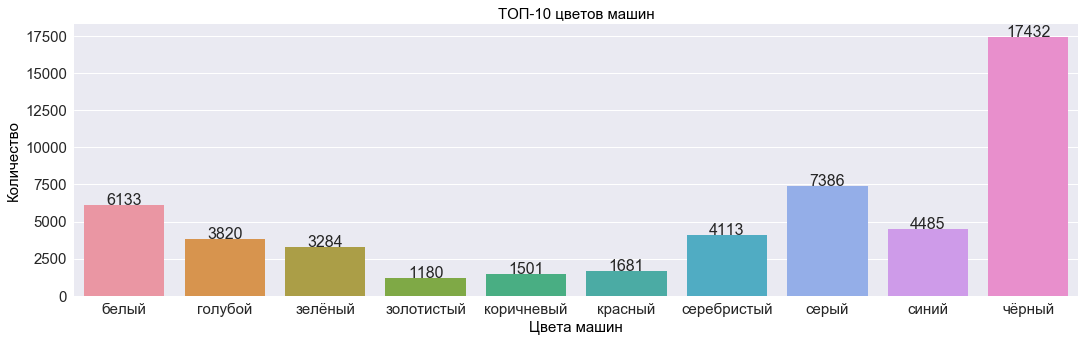

In [35]:
share_count(all_data['color'], 'Цвета машин', 'Количество', 'ТОП-10 цветов машин')

In [36]:
print('Количество строк, где есть нули:', len(all_data[all_data['color']==0]))

Количество строк, где есть нули: 0


In [37]:
# категориальные переменные в число
for colum in ['color']:
    all_data[colum] = all_data[colum].astype('category').cat.codes
    
all_data['color'] = all_data['color'].astype(int)

**Комментарий**: *проведена обработка столбца, заменены названия цветов, а категориальные переменные на числовые. Согласно диаграмме самыми распространенными цветами являются черный и серый.*

### 8.2 Year

In [38]:
description_column_count(all_data['year'])

Длина столбца: 53149
Количество значений "NaN": 0
Минимальное значение: 1904
Максимальное значение: 2021


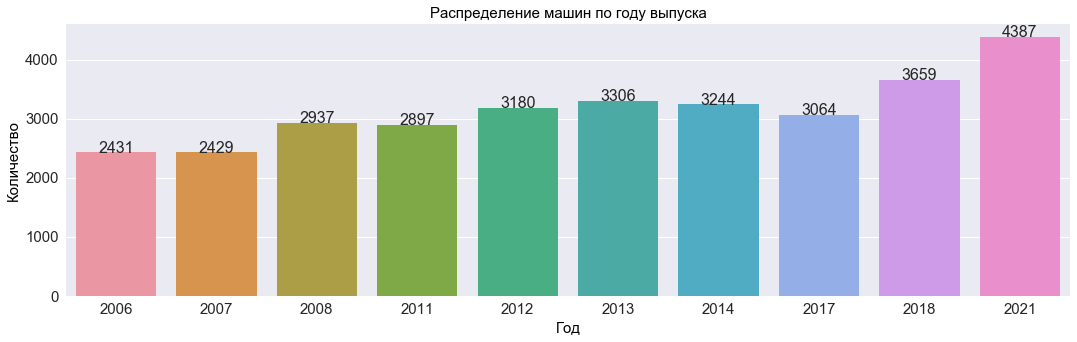

In [39]:
share_count(all_data['year'], 'Год', 'Количество', 'Распределение машин по году выпуска')

In [40]:
print('Количество, где есть нули:', len(all_data[all_data['year']==0]))

Количество, где есть нули: 0


**Комментарий**: *обработка не требуется. Согласно диаграмме больше всего продается машин 2021 года выпуска.*

### 8.3 Owner

In [41]:
description_column(all_data['owner'])

Количество уникальных значений в столбце: 8
Перечень уникальных значений: ['3 или более' '1\xa0владелец' '2\xa0владельца' 4 2 1 0 3]
Длина столбца: 53149
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 8


In [42]:
# заменим текстовые значения на числовые
all_data['owner'] = np.where(all_data['owner']=='3 или более', 3,
                    np.where(all_data['owner']=='1\xa0владелец', 1,
                    np.where(all_data['owner']=='2\xa0владельца', 2, all_data['owner'])))
all_data['owner'] = all_data['owner'].astype(int)

In [43]:
print('Количество, где есть нули:', len(all_data[all_data['owner']==0]))

Количество, где есть нули: 4344


Т.к. считается количество владельцев, то наличие нулей возможно (не было владельцев).

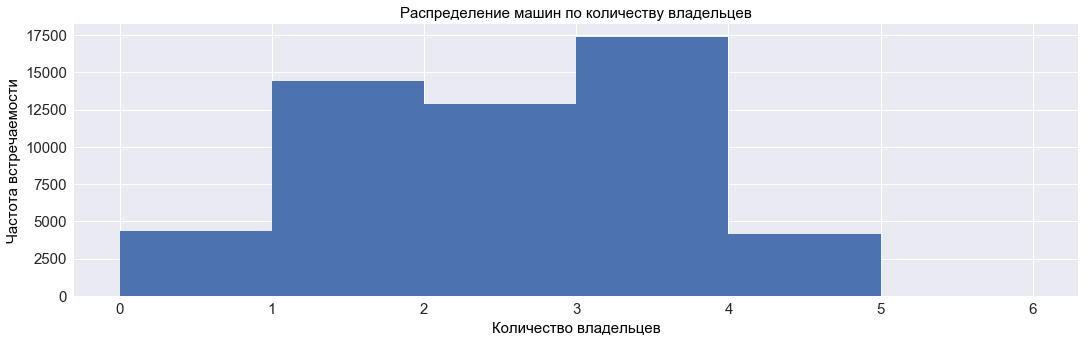

In [44]:
hist(all_data['owner'], 7, 1, "Частота встречаемости", "Количество владельцев", "Распределение машин по количеству владельцев")

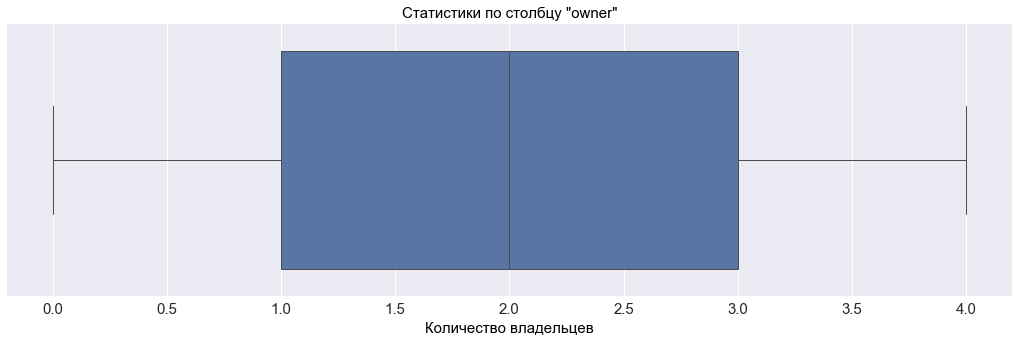

In [45]:
one_boxplot(all_data['owner'], 'Статистики по столбцу "owner"', 'Количество владельцев')

**Комментарий**: *проведена обработка, заменены текстовые значения кол-ва владельцев машин на числовые. Частотная диаграмма показала, что большинство машин, выставляемых на продажу имели от 1 до 4-х владельцев, в среднем 2-х.*

### 8.4 Currency

In [46]:
description_column(all_data['currency'])

Количество уникальных значений в столбце: 2
Перечень уникальных значений: ['RUB' 'RUR']
Длина столбца: 53149
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 2


In [47]:
print('Количество, где есть нули:', len(all_data[all_data['currency']==0]))

Количество, где есть нули: 0


In [48]:
# т.к. с сайта брались данные по цене в рублях, то заполним 499 строк значениями RUB
all_data['currency'] = np.where(all_data['currency']==0, 'RUB', all_data['currency'])

In [49]:
all_data = all_data.drop(['currency'], axis=1)

**Комментарий**: *обработка проведена, 0 заменены на 'RUB'. Позже принято решение удалить столбец, т.к. он не несет полезной информации.*

### 8.5 Doors	

In [50]:
description_column(all_data['doors'])

Количество уникальных значений в столбце: 5
Перечень уникальных значений: [5 4 2 3 0]
Длина столбца: 53149
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 4


In [51]:
print('Количество, где есть нули:', len(all_data[all_data['doors']==0]))

Количество, где есть нули: 1


In [52]:
# вставим вместо 0 среднее кол-во дверей
all_data['doors'] = np.where(all_data['doors'] == 0, all_data['doors'].median(), all_data['doors'])

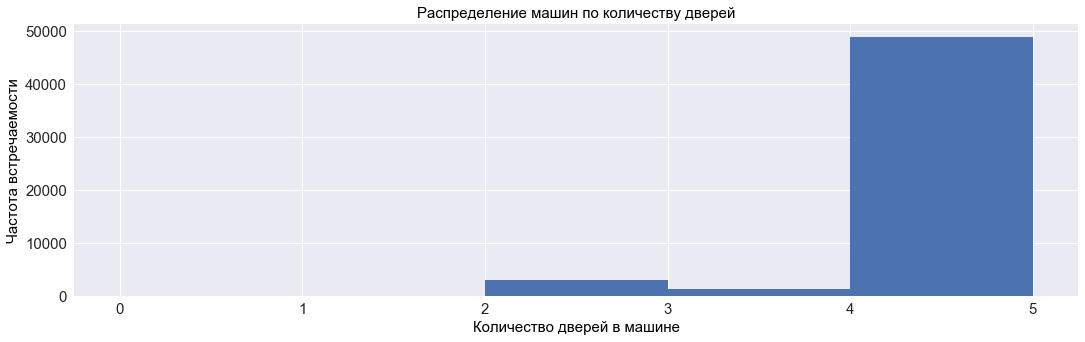

In [53]:
hist(all_data['doors'], 6, 1, "Частота встречаемости", "Количество дверей в машине", "Распределение машин по количеству дверей")

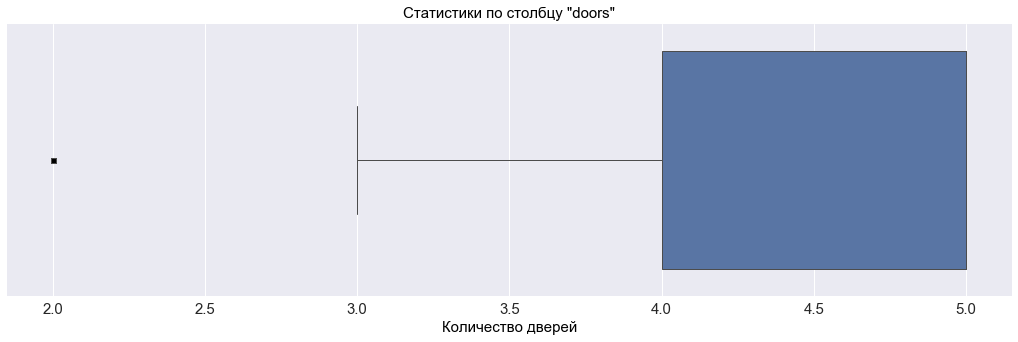

In [54]:
one_boxplot(all_data['doors'], 'Статистики по столбцу "doors"', 'Количество дверей')

**Комментарий**: *обработка проведена, 0 заменены на средние. Частотная диаграмма показала, что в большинстве машин от 4 до 5 дверей. Есть выброс - 2 двери в машине. Принято решение не удалять.*

### 8.6 BodyType

In [55]:
description_column(all_data['bodyType'])

Количество уникальных значений в столбце: 97
Перечень уникальных значений: ['лифтбек' 'внедорожник 5 дв.' 'хэтчбек 5 дв.' 'седан' 'компактвэн'
 'универсал 5 дв.' 'пикап одинарная кабина' 'хэтчбек 3 дв.' 'купе'
 'кабриолет' 'минивэн' 'пикап двойная кабина' 'внедорожник 3 дв.'
 'родстер' 'микровэн' 'седан 2 дв.' 'купе-хардтоп' 'фастбек' 'тарга'
 'внедорожник открытый' 'лимузин' 'пикап полуторная кабина'
 'седан-хардтоп' 'фургон' 'Седан' 'Внедорожник 5 дв.' 'Купе'
 'Хэтчбек 3 дв. GTC' 'Лимузин' 'Минивэн' 'Хэтчбек 5 дв.' 'Компактвэн'
 'Универсал 5 дв.' 'Седан Gran Coupe' 'Седан Long' 'Лифтбек'
 'Кабриолет GranCabrio' 'Минивэн XL' 'Внедорожник 5 дв. Cooper S'
 'Пикап Полуторная кабина' 'Фастбек' 'Купе-хардтоп' 'Внедорожник 3 дв.'
 'Хэтчбек 3 дв.' 'Внедорожник 5 дв. Prime' 'Минивэн L2'
 'Лифтбек Sportback' 'Хэтчбек 5 дв. X-Line' 'Родстер' 'Минивэн Grand'
 'Лифтбек Gran Coupe' 'Седан Type-S' 'Пикап Двойная кабина Double Cab'
 'Пикап Двойная кабина' 'Минивэн Long' 'Универсал 5 дв. Alltrack'
 '

In [56]:
# замена на строчные буквы
all_data['bodyType'] = all_data['bodyType'].apply(lambda x: x.lower())

In [57]:
print('Количество, где есть нули:', len(all_data[all_data['bodyType']==0]))

Количество, где есть нули: 0


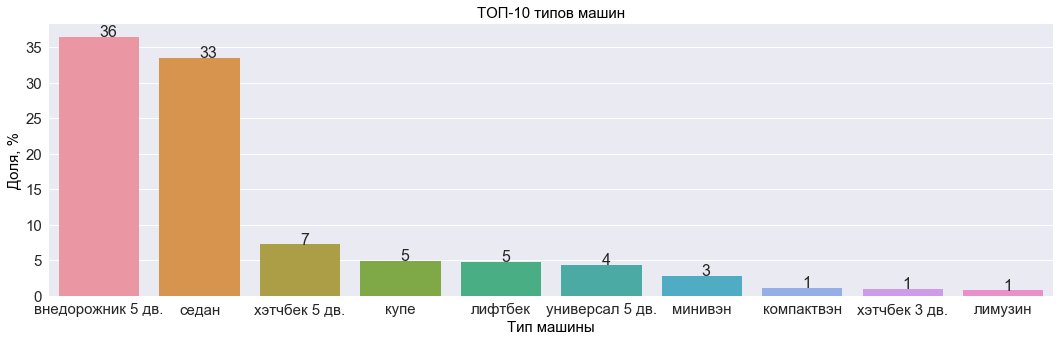

In [58]:
share(all_data['bodyType'], 'Тип машины', 'Доля, %', 'ТОП-10 типов машин')

In [59]:
# категориальные переменные в число
for colum in ['bodyType']:
    all_data[colum] = all_data[colum].astype('category').cat.codes

**Комментарий**: *обработка проведена, в названиях заменены заглавные буквы на строчные, категориальные переменные переведены в числовые. Согласно диаграмме чаще всего продаются внедорожники или седаны.*

### 8.7 Brand

In [60]:
description_column(all_data['brand'])

Количество уникальных значений в столбце: 66
Перечень уникальных значений: ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI' 'VAZ' 'RENAULT' 'LAMBORGHINI'
 'OPEL' 'ZIL' 'KIA' 'PORSCHE' 'CITROEN' 'MASERATI' 'LIFAN' 'HYUNDAI'
 'PEUGEOT' 'JAGUAR' 'CHRYSLER' 'BENTLEY' 'MAZDA' 'GENESIS' 'CHEVROLET'
 'SUZUKI' 'TESLA' 'CHERY' 'LAND_ROVER' 'MINI' 'GAZ' 'DODGE' 'FORD' 'HAVAL'
 'SUBARU' 'JEEP' 'FIAT' 'UAZ' 'IRAN_KHODRO' 'DERWAYS' 'DAEWOO' 'GEELY'
 'SSANG_YONG' 'GREAT_WALL' 'ALFA_ROMEO' 'HUMMER' 'FERRARI' 'TAGAZ' 'ACURA'
 'CADILLAC' 'ZOTYE' 'MOSCVICH' 'FOTON' 'ZAZ' 'ROLLS_ROYCE' 'CHANGAN'
 'SEAT' 'SMART' 'CHERYEXEED' 'ROVER' 'DATSUN']
Длина столбца: 53149
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 41


In [61]:
# замена на строчные буквы
all_data['brand'] = all_data['brand'].apply(lambda x: x.lower())

In [62]:
print('Количество, где есть нули:', len(all_data[all_data['brand']==0]))

Количество, где есть нули: 0


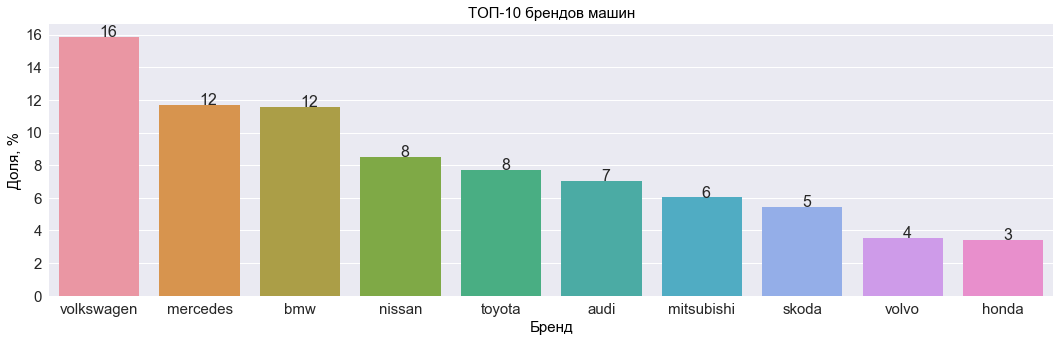

In [63]:
share(all_data['brand'], 'Бренд', 'Доля, %', 'ТОП-10 брендов машин')

In [64]:
# категориальные переменные в число
for colum in ['brand']:
    all_data[colum] = all_data[colum].astype('category').cat.codes

**Комментарий**: *обработка проведена, категориальные переменные заменены на числовые. Согласно диаграмме чаще всего продают машины марки volkswagen, mersedes, bmw.*

### 8.8 Displacement

In [65]:
description_column_count(all_data['displacement'])

Длина столбца: 53149
Количество значений "NaN": 0
Минимальное значение: 0
Максимальное значение: 7680


In [66]:
print('Количество, где есть нули:', len(all_data[all_data['displacement']==0]))

Количество, где есть нули: 65


In [67]:
# заменим нули на среднее
all_data['displacement'] = np.where(all_data['displacement']==0, all_data['displacement'].median(), all_data['displacement'])

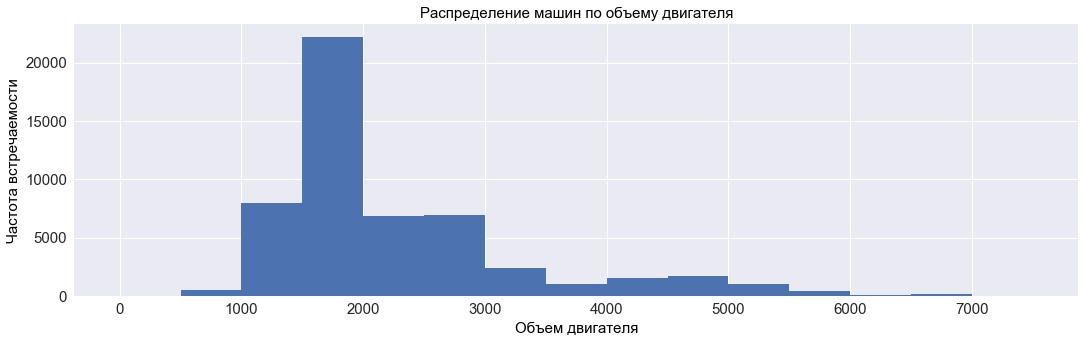

In [68]:
hist(all_data['displacement'], 8000, 500, "Частота встречаемости", "Объем двигателя","Распределение машин по объему двигателя")

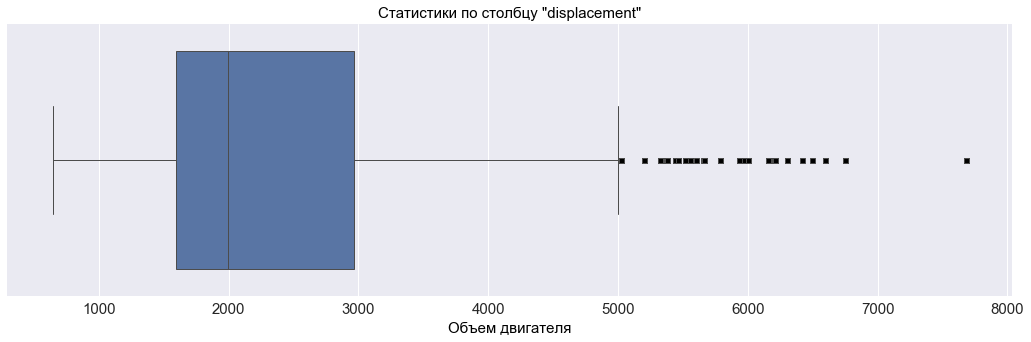

In [69]:
one_boxplot(all_data['displacement'], 'Статистики по столбцу "displacement"', 'Объем двигателя')

In [70]:
# определим границы выбросов
outliers(all_data['displacement'])

25-й квартиль: 1598.0, 75-й квартиль: 2967.0, IQR: 1369.0, границы выбросов: [-455.5,5020.5].


In [71]:
# проведем очистку данных
all_data=all_data.loc[all_data['displacement'].between(delete_outliers(all_data['displacement'])[0],
                                                      delete_outliers(all_data['displacement'])[1])]

**Комментарий**: *проведена обработка столбца, удалены выбросы. Согласно диаграмме распределения чаще всего продаются машины с объемом двигателя от 1500 до 2000.*

### 8.9 Engine_type	

In [72]:
description_column(all_data['engine_type'])

Количество уникальных значений в столбце: 5
Перечень уникальных значений: ['GASOLINE' 'DIESEL' 'HYBRID' 'ELECTRO' 'LPG']
Длина столбца: 51018
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 4


In [73]:
# замена на строчные буквы
all_data['engine_type'] = all_data['engine_type'].apply(lambda x: x.lower())

In [74]:
print('Количество, где есть нули:', len(all_data[all_data['engine_type']==0]))

Количество, где есть нули: 0


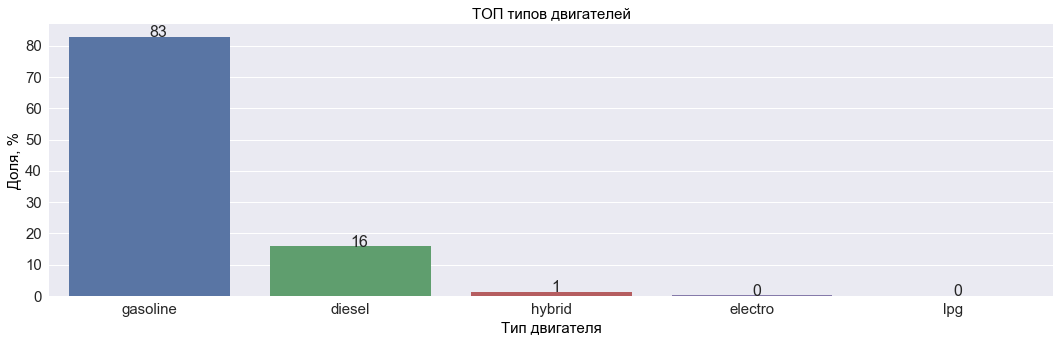

In [75]:
share(all_data['engine_type'], 'Тип двигателя', 'Доля, %', 'ТОП типов двигателей')

In [76]:
# категориальные переменные в число
for colum in ['engine_type']:
    all_data[colum] = all_data[colum].astype('category').cat.codes

**Комментарий**: *проведена обработка данных, категориальные переменные заменены на числовые. Согласно диаграмме чаще всего продаются машины с типов двигателя: gasoline, diesel.*

### 8.10 Gear_type	

In [77]:
description_column(all_data['gear_type'])

Количество уникальных значений в столбце: 3
Перечень уникальных значений: ['FORWARD_CONTROL' 'ALL_WHEEL_DRIVE' 'REAR_DRIVE']
Длина столбца: 51018
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 3


In [78]:
print('Количество, где есть нули:', len(all_data[all_data['gear_type']==0]))

Количество, где есть нули: 0


In [79]:
# замена на строчные буквы
all_data['gear_type'] = all_data['gear_type'].apply(lambda x: x.lower())

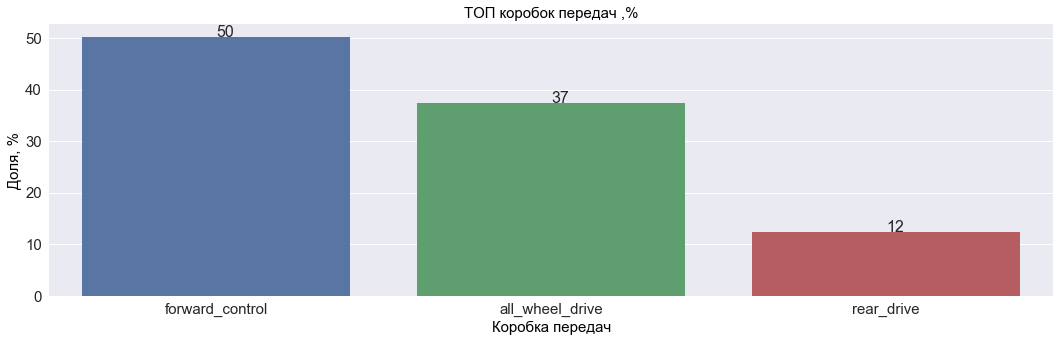

In [80]:
share(all_data['gear_type'],"Коробка передач", "Доля, %", 'ТОП коробок передач ,%')

In [81]:
# категориальные переменные в число
for colum in ['gear_type']:
    all_data[colum] = all_data[colum].astype('category').cat.codes

**Комментарий**: *проведена обработка данных, категориальные переменные заменены на числовые. Согласно диаграмме чаще всео встречаются машины с коробками передач forward_control.*

### 8.11 Transmission

In [82]:
description_column(all_data['transmission'])

Количество уникальных значений в столбце: 4
Перечень уникальных значений: ['ROBOT' 'MECHANICAL' 'AUTOMATIC' 'VARIATOR']
Длина столбца: 51018
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 4


In [83]:
print('Количество, где есть нули:', len(all_data[all_data['transmission']==0]))

Количество, где есть нули: 0


In [84]:
# замена на строчные буквы
all_data['transmission'] = all_data['transmission'].apply(lambda x: x.lower())

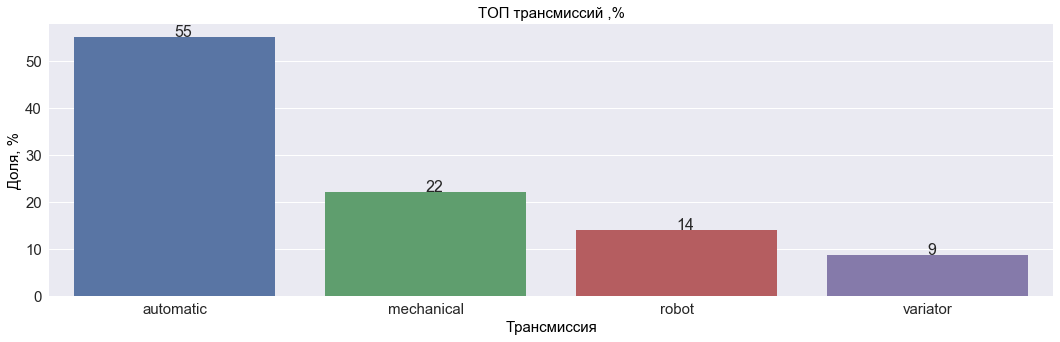

In [85]:
share(all_data['transmission'],"Трансмиссия", "Доля, %", 'ТОП трансмиссий ,%')

In [86]:
# категориальные переменные в число
for colum in ['transmission']:
    all_data[colum] = all_data[colum].astype('category').cat.codes

**Комментарий**: *обработка проведена, категориальные переменные заменены на числовые. Согласно диаграмме больше всего продают машин с автоматической трансмиссией.*

### 8.12 Power

In [87]:
description_column_count(all_data['power'])

Длина столбца: 51018
Количество значений "NaN": 0
Минимальное значение: 27
Максимальное значение: 762


In [88]:
print('Количество, где есть нули:', len(all_data[all_data['power']==0]))

Количество, где есть нули: 0


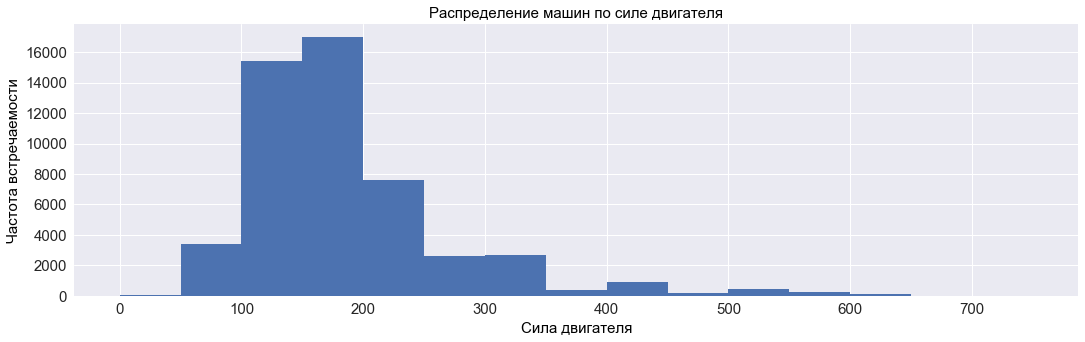

In [89]:
hist(all_data['power'], 800, 50, "Частота встречаемости", "Сила двигателя", "Распределение машин по силе двигателя")

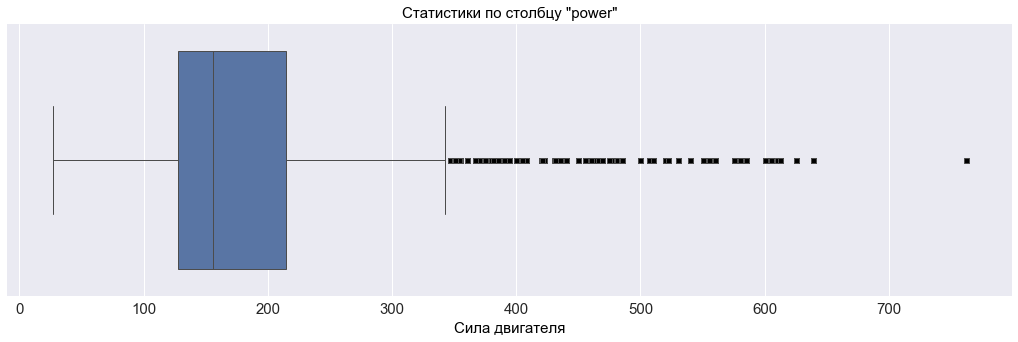

In [90]:
one_boxplot(all_data['power'], 'Статистики по столбцу "power"', 'Сила двигателя')

In [91]:
outliers(all_data['power'])

25-й квартиль: 128.0, 75-й квартиль: 215.0, IQR: 87.0, границы выбросов: [-2.5,345.5].


In [92]:
all_data=all_data.loc[all_data['power'].between(delete_outliers(all_data['power'])[0],
                                                      delete_outliers(all_data['power'])[1])]

**Комментарий**: *обработка проведена, удалены выбросы. Согласно диаграмме распределения признака больше всего распространены машины с милой двигателя от 150 до 200.*

### 8.13 Power_kvt

In [93]:
description_column_count(all_data['power_kvt'])

Длина столбца: 48682
Количество значений "NaN": 0
Минимальное значение: 20
Максимальное значение: 280


In [94]:
print('Количество, где есть нули:', len(all_data[all_data['power_kvt']==0]))

Количество, где есть нули: 0


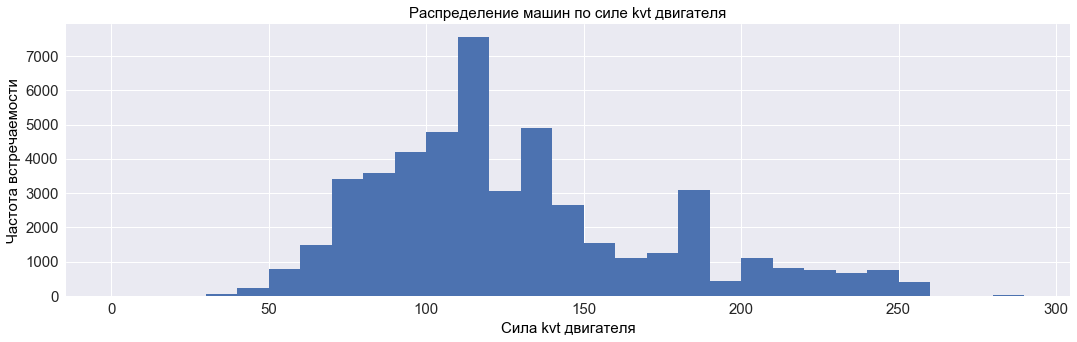

In [95]:
hist(all_data['power_kvt'], 300, 10, "Частота встречаемости", "Сила kvt двигателя", "Распределение машин по силе kvt двигателя")

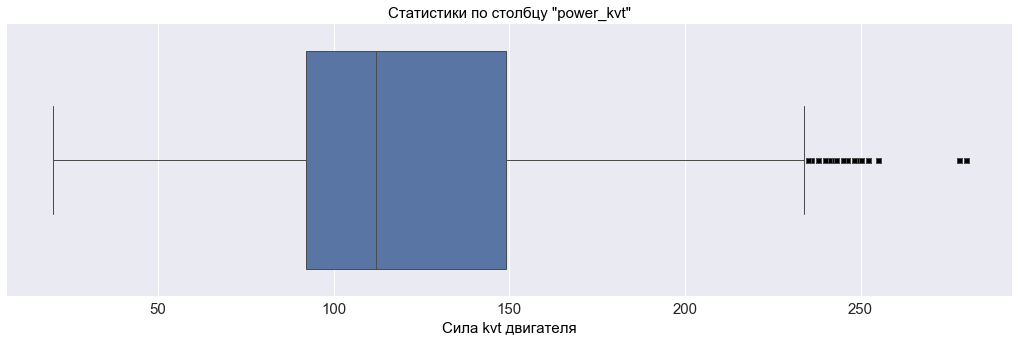

In [96]:
one_boxplot(all_data['power_kvt'], 'Статистики по столбцу "power_kvt"', 'Сила kvt двигателя')

In [97]:
outliers(all_data['power_kvt'])

25-й квартиль: 92.0, 75-й квартиль: 149.0, IQR: 57.0, границы выбросов: [6.5,234.5].


In [98]:
all_data=all_data.loc[all_data['power_kvt'].between(delete_outliers(all_data['power_kvt'])[0],
                                                      delete_outliers(all_data['power_kvt'])[1])]

**Комментарий**: *обработка проведена, удалены выбросы. Согласно диаграмме наиболее распространены машины с силой kvt от 100  до 150.*

### 8.14 Acceleration

In [99]:
description_column_count(all_data['acceleration'])

Длина столбца: 46928
Количество значений "NaN": 1877
Минимальное значение: 0.0
Максимальное значение: 35.0


In [100]:
print('Количество, где есть нули:', len(all_data[all_data['acceleration']==0]))

Количество, где есть нули: 50


In [101]:
# заменим нули на среднее
all_data['acceleration'] = np.where(all_data['acceleration']==0, all_data['acceleration'].median(), all_data['acceleration'])

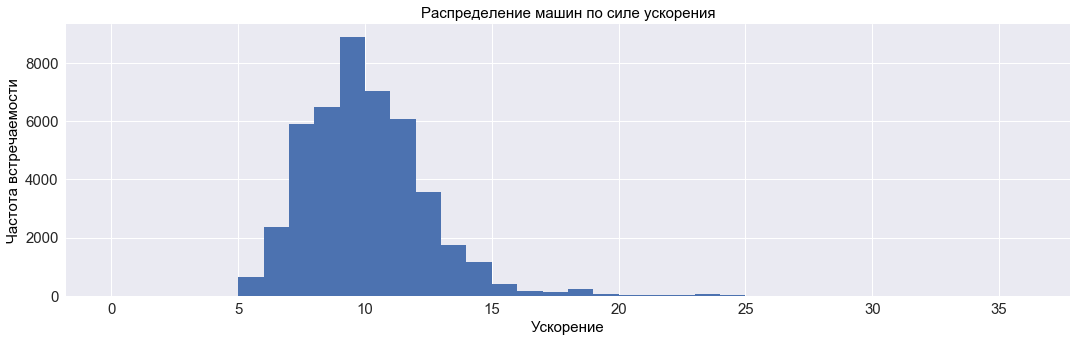

In [102]:
hist(all_data['acceleration'], 37, 1, "Частота встречаемости", "Ускорение", "Распределение машин по силе ускорения")

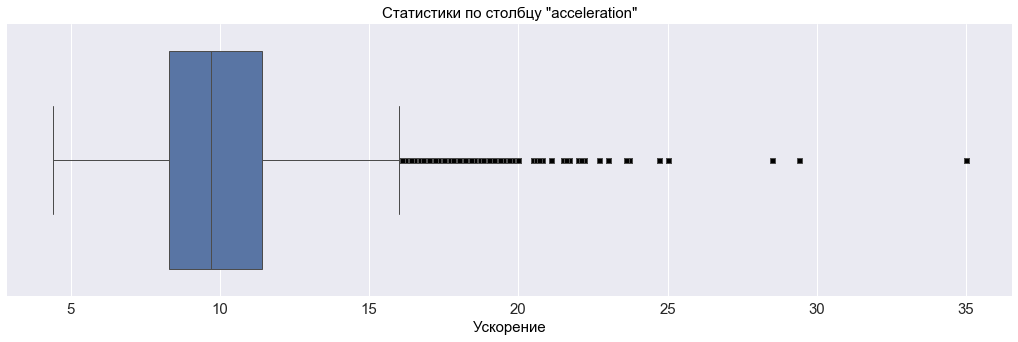

In [103]:
one_boxplot(all_data['acceleration'], 'Статистики по столбцу "acceleration"', 'Ускорение')

In [104]:
outliers(all_data['acceleration'])

25-й квартиль: 8.3, 75-й квартиль: 11.4, IQR: 3.0999999999999996, границы выбросов: [3.6500000000000012,16.05].


In [105]:
all_data=all_data.loc[all_data['acceleration'].between(delete_outliers(all_data['acceleration'])[0],
                                                      delete_outliers(all_data['acceleration'])[1])]

**Комментарий**: *обработка проведена, удалены выбросы. Согласно диаграмме наиболее распространены машины с силой ускорения от 9 до 10.*

### 8.15 Clearance_min

In [106]:
description_column_count(all_data['clearance_min'])

Длина столбца: 44344
Количество значений "NaN": 641
Минимальное значение: 0.0
Максимальное значение: 300.0


In [107]:
print('Количество, где есть нули:', len(all_data[all_data['clearance_min']==0]))

Количество, где есть нули: 13


In [108]:
# заменим нули на среднее
all_data['clearance_min'] = np.where(all_data['clearance_min']==0, all_data['clearance_min'].median(), 
                                     all_data['clearance_min'])

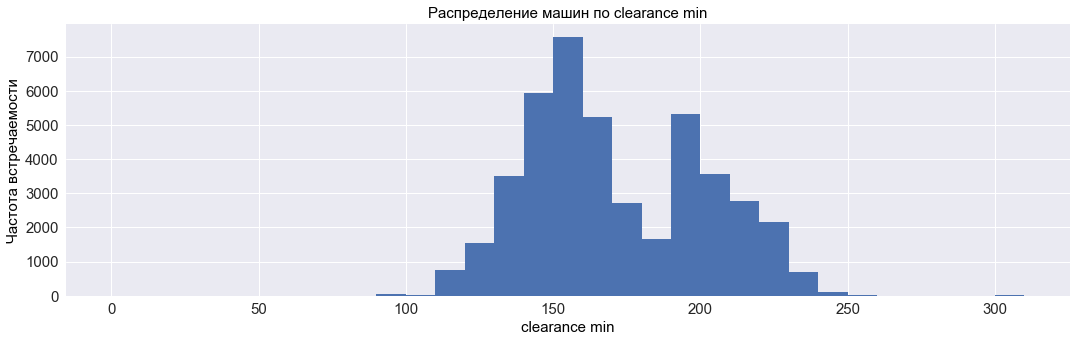

In [109]:
hist(all_data['clearance_min'], 320, 10, "Частота встречаемости", "clearance min", "Распределение машин по clearance min")

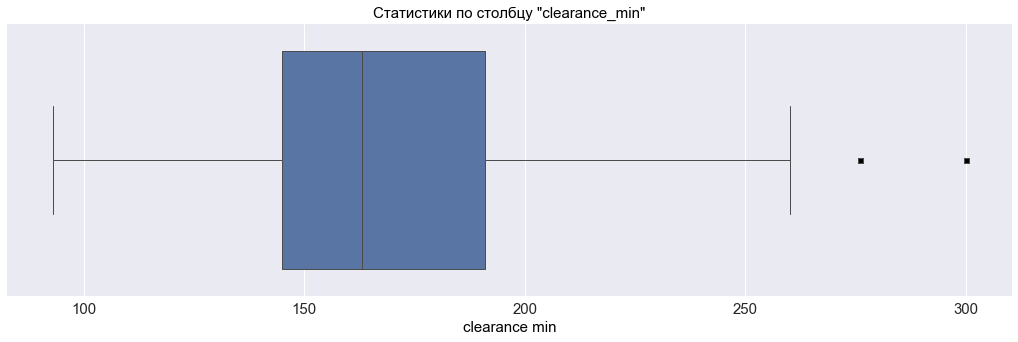

In [110]:
one_boxplot(all_data['clearance_min'], 'Статистики по столбцу "clearance_min"', 'clearance min')

In [111]:
outliers(all_data['clearance_min'])

25-й квартиль: 145.0, 75-й квартиль: 191.0, IQR: 46.0, границы выбросов: [76.0,260.0].


In [112]:
all_data=all_data.loc[all_data['clearance_min'].between(delete_outliers(all_data['clearance_min'])[0],
                                                      delete_outliers(all_data['clearance_min'])[1])]

**Комментарий**: *проведена обработка, удалены выбросы. Согласно диаграмме наиболее распросранены машины с clearance min от 140 до 150 и 190-200.*

### 8.16 Fuel_rate

In [113]:
description_column_count(all_data['fuel_rate'])

Длина столбца: 43664
Количество значений "NaN": 2225
Минимальное значение: 0.0
Максимальное значение: 19.2


In [114]:
print('Количество, где есть нули:', len(all_data[all_data['fuel_rate']==0]))

Количество, где есть нули: 1220


In [115]:
# заменим нули на среднее
all_data['fuel_rate'] = np.where(all_data['fuel_rate']==0, all_data['fuel_rate'].median(), all_data['fuel_rate'])

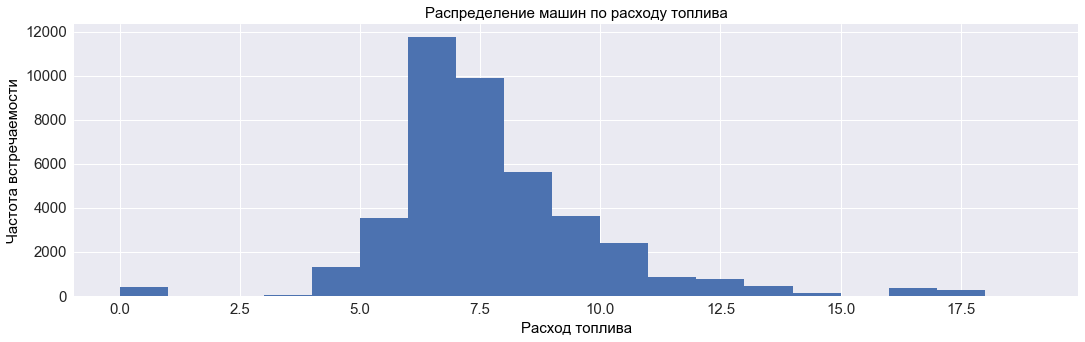

In [116]:
hist(all_data['fuel_rate'], 20, 1, "Частота встречаемости", "Расход топлива", "Распределение машин по расходу топлива")

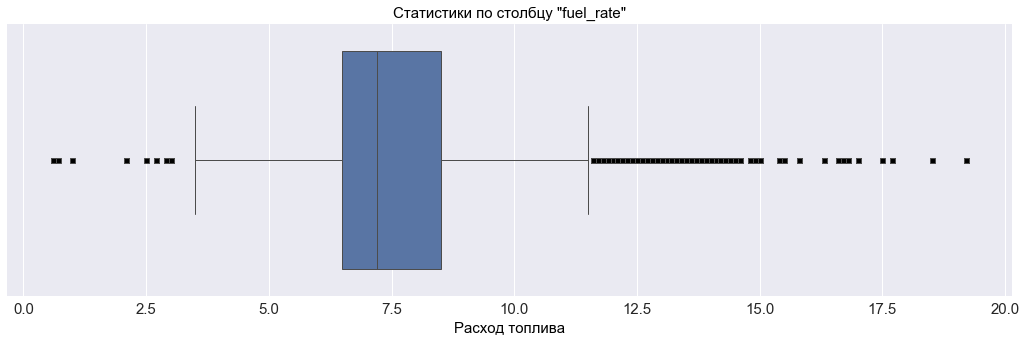

In [117]:
one_boxplot(all_data['fuel_rate'], 'Статистики по столбцу "fuel_rate"', 'Расход топлива')

In [118]:
outliers(all_data['fuel_rate'])

25-й квартиль: 6.5, 75-й квартиль: 8.5, IQR: 2.0, границы выбросов: [3.5,11.5].


In [119]:
all_data=all_data.loc[all_data['fuel_rate'].between(delete_outliers(all_data['fuel_rate'])[0],
                                                      delete_outliers(all_data['fuel_rate'])[1])]

**Комментарий**: *обработка проведена, удалены выбросы. Наиболее распространены машины с fuel rate от 6 до 7.*

### 8.17 Mileage

In [120]:
description_column_count(all_data['mileage'])

Длина столбца: 38859
Количество значений "NaN": 0
Минимальное значение: 0
Максимальное значение: 1000000


In [121]:
print('Количество, где есть нули:', len(all_data[all_data['mileage']==0]))

Количество, где есть нули: 4327


In [122]:
# заменим нули на среднее
all_data['mileage'] = np.where(all_data['mileage']==0, all_data['mileage'].median(), all_data['mileage'])

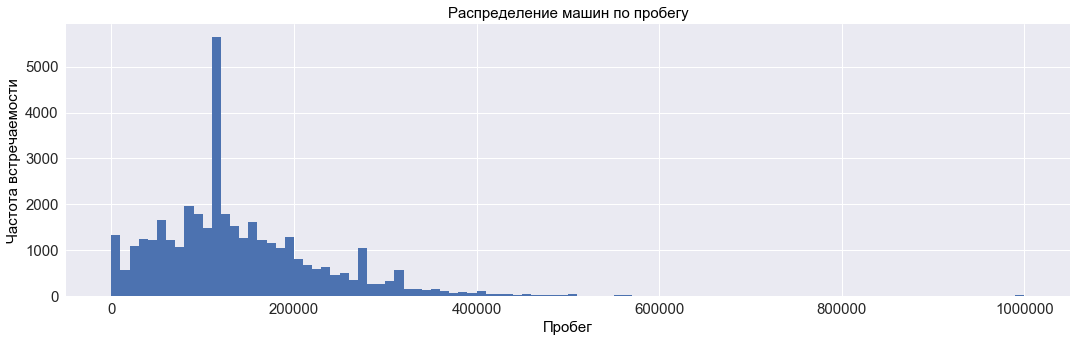

In [123]:
hist(all_data['mileage'], 1000100, 10000, "Частота встречаемости", "Пробег", "Распределение машин по пробегу")

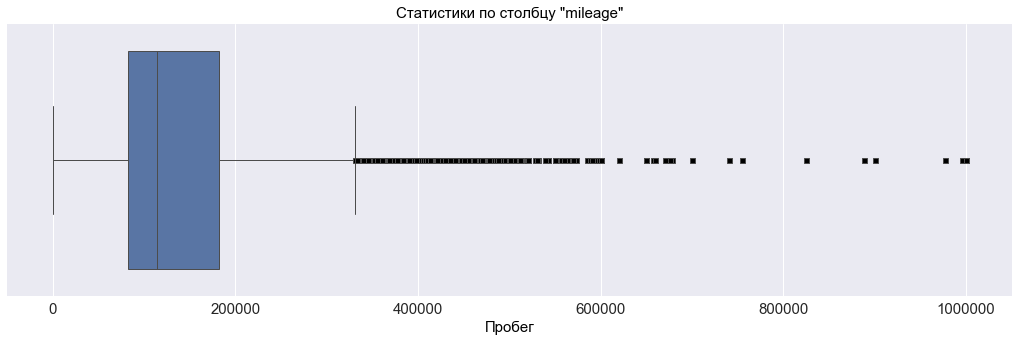

In [124]:
one_boxplot(all_data['mileage'], 'Статистики по столбцу "mileage"', 'Пробег')

In [125]:
outliers(all_data['mileage'])

25-й квартиль: 82521.5, 75-й квартиль: 182000.0, IQR: 99478.5, границы выбросов: [-66696.25,331217.75].


In [126]:
all_data=all_data.loc[all_data['mileage'].between(delete_outliers(all_data['mileage'])[0],
                                                      delete_outliers(all_data['mileage'])[1])]

**Комментарий**: *обработка проведена, удалены выбросы.*

### 8.18 Model_name

In [127]:
description_column(all_data['model_name'])

Количество уникальных значений в столбце: 531
Перечень уникальных значений: ['OCTAVIA' 'SUPERB' 'OCTAVIA_RS' 'YETI' 'KODIAQ' 'RAPID' 'FABIA'
 'ROOMSTER' 'KAROQ' 'FABIA_RS' 'FELICIA' 'Q5' 'Q7' 'Q3' 'A4' 'A3' 'A5'
 'A6' 'TT' 'A1' 'ALLROAD' '80' 'A8' 'A7' 'A4_ALLROAD' 'Q8' '100' 'RSQ3'
 '90' 'COUPE' 'A2' 'TTS' 'S4' 'S3' '200' 'CR_V' 'ACCORD' 'CIVIC'
 'CROSSTOUR' 'ELYSION' 'STREAM' 'FIT' 'SHUTTLE' 'FREED' 'PILOT' 'JAZZ'
 'CR_Z' 'LEGEND' 'STEPWAGON' 'CIVIC_TYPE_R' 'FR_V' 'CR_X' 'ZEST' 'INSPIRE'
 'VEZEL' 'PRELUDE' 'SABER' 'S2000' 'CROSSROAD' 'INSIGHT' 'HR_V' 'CONCERTO'
 'V60_CROSS_COUNTRY' 'XC40' 'XC60' 'C30' 'V50' 'XC90' 'V90_CROSS_COUNTRY'
 'S60' 'XC70' 'V40_CC' 'S40' 'V40' 'S80' 'S60_CROSS_COUNTRY' '850' 'V60'
 'V70' 'S70' 'C70' 'S90' '240_SERIES' '460' '740' '760' '440' 'X5' 'X6'
 'X7' 'X3' '5ER' 'X2' 'Z4' 'X1' '6ER' '7ER' '1ER' '3ER' '4' 'X4' '2ER'
 '2GRANDTOURER' '2ACTIVETOURER' 'Z3' 'TEANA' 'QASHQAI' 'X_TRAIL' 'MURANO'
 'NAVARA' 'PATHFINDER' 'NOTE' 'TIIDA' 'JUKE' 'TERRANO' 'ALMERA_CLA

In [128]:
# замена на строчные буквы
all_data['model_name'] = all_data['model_name'].apply(lambda x: x.lower())

In [129]:
print('Количество, где есть нули:', len(all_data[all_data['model_name']==0]))

Количество, где есть нули: 0


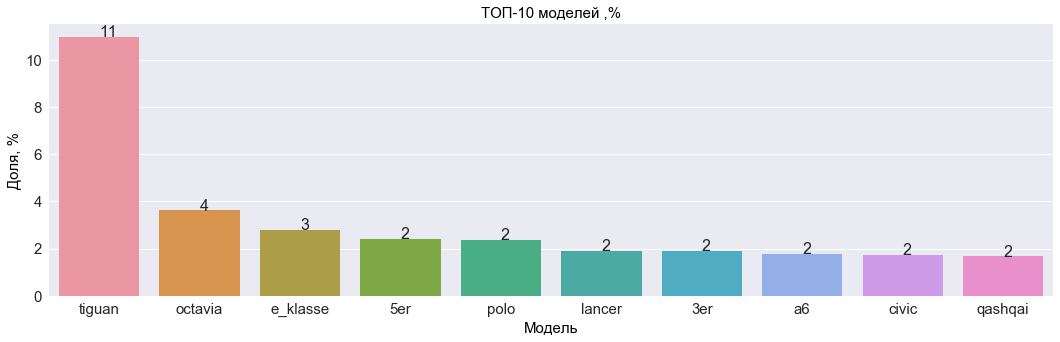

In [130]:
share(all_data['model_name'],"Модель", "Доля, %", 'ТОП-10 моделей ,%')

In [131]:
# категориальные переменные в число
for colum in ['model_name']:
    all_data[colum] = all_data[colum].astype('category').cat.codes

**Комментарий**: *обработка проведена, категориальные переменные переведены в числовые.*

### 8.19 Name

In [132]:
description_column(all_data['name'])

Количество уникальных значений в столбце: 1812
Перечень уникальных значений: ['1.2 AMT (105 л.с.)' '1.6 MT (110 л.с.)' 'DSG 1.8 AMT (152 л.с.)' ...
 '200 d длинный 2.1d MT (136 л.с.)' 'Grand 2.2d AT (197 л.с.) 4WD'
 '4.4d AT (313 л.с.) 4WD']
Длина столбца: 37769
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 464


In [133]:
print('Количество, где есть нули:', len(all_data[all_data['name']==0]))

Количество, где есть нули: 0


In [134]:
# категориальные переменные в число
for colum in ['name']:
    all_data[colum] = all_data[colum].astype('category').cat.codes

**Комментарий**: *обработка проведена, категориальные переменные переведены в числовые.*

### 8.20 Vendor	

In [135]:
description_column(all_data['vendor'])

Количество уникальных значений в столбце: 7
Перечень уникальных значений: ['EUROPEAN' 'JAPANESE' 'RUSSIAN' 'KOREAN' 'CHINESE' 'AMERICAN'
 'VENDOR_UNKNOWN']
Длина столбца: 37769
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 6


In [136]:
print('Количество, где есть нули:', len(all_data[all_data['vendor']==0]))

Количество, где есть нули: 0


In [137]:
# замена на строчные буквы
all_data['vendor'] = all_data['vendor'].apply(lambda x: x.lower())

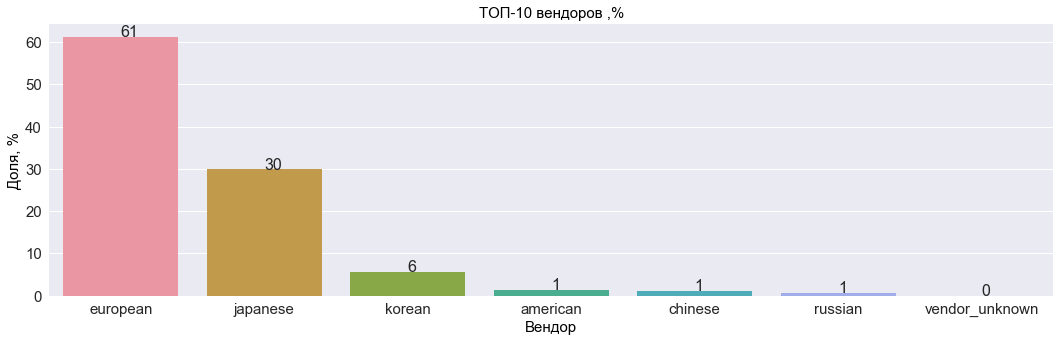

In [138]:
share(all_data['vendor'],"Вендор", "Доля, %", 'ТОП-10 вендоров ,%')

In [139]:
# категориальные переменные в число
for colum in ['vendor']:
    all_data[colum] = all_data[colum].astype('category').cat.codes

**Комментарий**: *обработка проведена, категориальные переменные заменены на числовые.*

### 8.21 Pts

In [140]:
description_column(all_data['pts'])

Количество уникальных значений в столбце: 5
Перечень уникальных значений: ['Оригинал' 'Дубликат' nan 'DUPLICATE' 'ORIGINAL' 0]
Длина столбца: 37769
Количество значений "NaN": 1
Количество значений, встретившихся в столбце более 10 раз: 5


In [141]:
print('Количество, где есть нули:', len(all_data[all_data['pts']==0]))

Количество, где есть нули: 3624


In [142]:
all_data['pts'] = np.where(all_data['pts']=='DUPLICATE', 'Дубликат',
                  np.where(all_data['pts']=='ORIGINAL', 'Оригинал', 
                  np.where(all_data['pts']== np.nan, 'Оригинал', all_data['pts'])))

In [143]:
all_data['pts'] = all_data['pts'].astype(str)

In [144]:
# замена на строчные буквы
all_data['pts'] = all_data['pts'].apply(lambda x: x.lower())

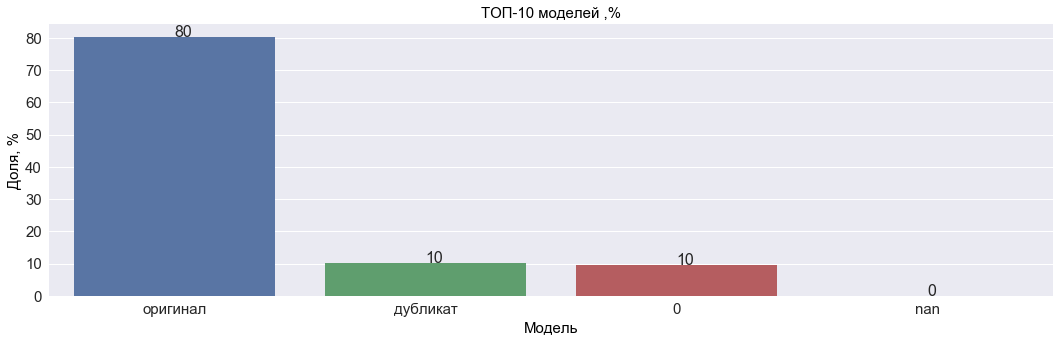

In [145]:
share(all_data['pts'],"Модель", "Доля, %", 'ТОП-10 моделей ,%')

In [146]:
# категориальные переменные в число
for colum in ['pts']:
    all_data[colum] = all_data[colum].astype('category').cat.codes

**Комментарий**: *обработка проведена, категориальные переменные заменены на числовые.*

### 8.22 Wheel

In [147]:
description_column(all_data['wheel'])

Количество уникальных значений в столбце: 4
Перечень уникальных значений: ['Левый' 'Правый' 'LEFT' 'RIGHT']
Длина столбца: 37769
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 4


In [148]:
print('Количество, где есть нули:', len(all_data[all_data['wheel']==0]))

Количество, где есть нули: 0


In [149]:
all_data['wheel'] = np.where(all_data['wheel']=='LEFT', 'Левый',
                  np.where(all_data['wheel']=='RIGHT', 'Правый', all_data['wheel']))

In [150]:
# замена на строчные буквы
all_data['wheel'] = all_data['wheel'].apply(lambda x: x.lower())

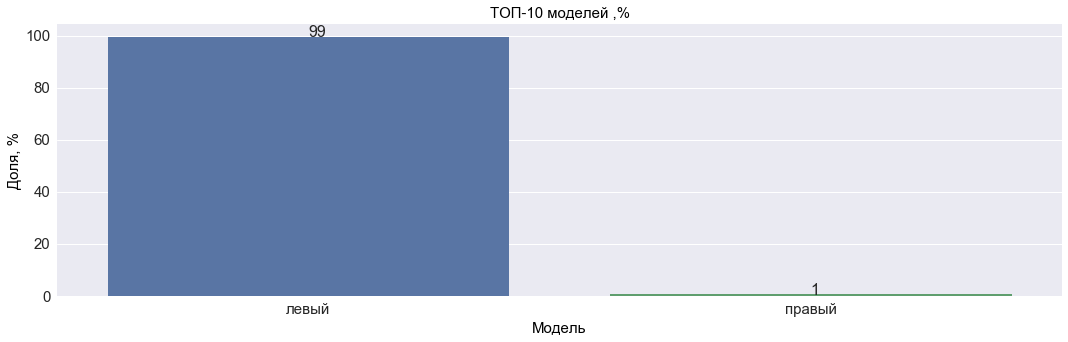

In [151]:
share(all_data['wheel'],"Модель", "Доля, %", 'ТОП-10 моделей ,%')

In [152]:
# категориальные переменные в число
for colum in ['wheel']:
    all_data[colum] = all_data[colum].astype('category').cat.codes

**Комментарий**: *обработка проведена, категриальные переменные заменены на числовые.*

In [153]:
all_data.head()

,color,year,owner,doors,bodyType,brand,displacement,engine_type,gear_type,transmission,power,power_kvt,acceleration,clearance_min,fuel_rate,mileage,model_name,name,vendor,pts,wheel,price,sample
0,13,2014,3,5.0,24,51,1197.0,2,1,2,105,77,10.5,155.0,5.0,74000.0,330,13,2,3,0,0,test
1,16,2017,1,5.0,24,51,1598.0,2,1,1,110,81,10.8,156.0,6.4,60563.0,330,226,2,3,0,0,test
2,12,2014,1,5.0,24,51,1798.0,2,1,2,152,112,8.7,139.0,7.1,88000.0,442,1681,2,3,0,0,test
3,6,2014,1,5.0,24,51,1598.0,2,1,0,110,81,12.2,155.0,6.7,95000.0,330,183,2,3,0,0,test
4,1,2012,1,5.0,24,51,1798.0,2,1,0,152,112,8.8,164.0,7.7,58536.0,330,315,2,3,0,0,test


In [154]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37769 entries, 0 to 53148
Data columns (total 23 columns):
color            37769 non-null int32
year             37769 non-null int64
owner            37769 non-null int32
doors            37769 non-null float64
bodyType         37769 non-null int8
brand            37769 non-null int8
displacement     37769 non-null float64
engine_type      37769 non-null int8
gear_type        37769 non-null int8
transmission     37769 non-null int8
power            37769 non-null int64
power_kvt        37769 non-null int64
acceleration     37769 non-null float64
clearance_min    37769 non-null float64
fuel_rate        37769 non-null float64
mileage          37769 non-null float64
model_name       37769 non-null int16
name             37769 non-null int16
vendor           37769 non-null int8
pts              37769 non-null int8
wheel            37769 non-null int8
price            37769 non-null int64
sample           37769 non-null object
dtypes: floa

In [155]:
all_data.describe()

,color,year,owner,doors,bodyType,brand,displacement,engine_type,gear_type,transmission,power,power_kvt,acceleration,clearance_min,fuel_rate,mileage,model_name,name,vendor,pts,wheel,price
count,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,37769.000000,3.776900e+04
mean,9.836427,2012.489237,1.901162,4.493526,30.784453,39.320527,2030.462602,1.666605,0.798936,0.865127,164.079933,120.657762,9.846096,168.080807,7.429209,130304.314279,278.446689,662.971167,2.388149,2.610871,0.005163,5.923387e+05
std,5.867246,6.459604,1.140612,0.688296,23.853352,20.156442,598.254814,0.753863,0.613886,1.026922,49.840023,36.687106,2.039298,28.425528,1.480423,74990.681175,163.979031,497.263699,0.704626,0.901938,0.071669,1.024746e+06
min,0.000000,1956.000000,0.000000,2.000000,0.000000,0.000000,657.000000,0.000000,0.000000,0.000000,27.000000,20.000000,4.900000,93.000000,3.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,4.000000,2009.000000,1.000000,4.000000,4.000000,27.000000,1596.000000,2.000000,0.000000,0.000000,125.000000,92.000000,8.400000,148.000000,6.500000,80000.000000,107.000000,219.000000,2.000000,3.000000,0.000000,0.000000e+00
50%,12.000000,2013.000000,2.000000,5.000000,29.000000,43.000000,1984.000000,2.000000,1.000000,0.000000,150.000000,110.000000,9.700000,163.000000,7.200000,113800.000000,330.000000,558.000000,2.000000,3.000000,0.000000,0.000000e+00
75%,16.000000,2017.000000,3.000000,5.000000,49.000000,58.000000,2359.000000,2.000000,1.000000,2.000000,190.000000,140.000000,11.300000,191.000000,8.200000,175000.000000,422.000000,1033.000000,3.000000,3.000000,0.000000,9.650000e+05
max,16.000000,2021.000000,4.000000,5.000000,77.000000,65.000000,4988.000000,4.000000,2.000000,3.000000,318.000000,234.000000,16.000000,260.000000,11.500000,331000.000000,530.000000,1811.000000,6.000000,3.000000,1.000000,2.870000e+07


**Комментарий**: *в процессе обработки dataframe были обработаны нулевые значения (в данном случае 0 = NaN из-за особенностей сбора данных с сайта auto.ru), удалены выбросы, категориальные переменные переведены в числовые. Итоговый dataframe включается в себя 37851 строку и 23 столбца.*

### 9. Построение модели

In [156]:
# Делим на тестовую и тренировочную части
X = all_data.query('sample == "train"').drop(['sample'], axis=1)
X_sub = all_data.query('sample == "test"').drop(['sample'], axis=1)

In [157]:
# определяем целевую переменную
y = X['price']

In [158]:
# удаляем столбец с целевой переменной
X = X.drop(['price'], axis=1)
X_sub = X_sub.drop(['price'], axis=1)

#### 9.1 Делим dataframe на тестовую и тренировочную части  в пропорции 20/80

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [160]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

#### 9.2 Создаем простую модель, которая бы предсказывала цену по типу двигателя

In [161]:
# Находим median по экземплярам displacement в трейне и размечаем тест
predict = X_test['displacement'].map(tmp_train.groupby('displacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 38.92%


В biseline 117%

#### 9.3 Создаем модель с помощью библиотеки CatBoost от Яндекса, которая хорошо работает с категориальными данными

In [162]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [163]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 3.41%


В biseline 15%

#### 9.4 Предсказываем цену машины

In [164]:
predict_submission = model.predict(X_sub)

In [165]:
X_sub['price'] = predict_submission

### 10. Выводы

Точность модели, предсказывающей стоимость автомобиля, составила 3,41%.
Такую точность удалось добиться благодаря:
* сбору актуальной информации по стоимости и характеристикам машин с сайта [Auto.ru](https://auto.ru/ "Сайт Auto.ru");
* проведению разведовательного анализа данных и их предобработке (удалению выбросов, замене категориальных переменных на числовые, а NaN на медианные значения).

Общий вывод таков: сбору данных и предобработке необходимо уделять должное внимание. Трата 80% времени на разведавательный анализ данных оправдана.